<a href="https://colab.research.google.com/github/ap0phasi/cerberusPy/blob/dev_headselection/tests/example_cerberus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modular CerberusTS Experimentation

First we make sure we are in the base working directory (this is probably not necessary if using the package):

In [1]:
!git clone --branch dev_headselection https://github.com/ap0phasi/cerberusPy

fatal: destination path 'cerberusPy' already exists and is not an empty directory.


Google Colab notebooks come with most of the packages we need, but we need to upgrade pandas and install accelerate.

In [2]:
import os
os.chdir("cerberusPy")

In [3]:
!python -m setup install

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based t

Then we import the necessary CerberusTS modules.

In [4]:
from cerberus_ts import Cerberus, train_cerberus
from cerberus_ts import TimeseriesDataPreparer, ResponseGenerator
from cerberus_ts import Foresight, train_foresight

import pandas as pd

Here we have the ability to do some custom configuration:

In [5]:
from cerberus_ts import CerberusConfig
CerberusConfig.set_masked_norm_zero = True

## Dataset Loading

Next we need a Pandas Dataframe of some wide-formatted mutlivariate timeseries data. Here we will use the Jena Climate Data found here: https://www.kaggle.com/datasets/mnassrib/jena-climate

In [6]:
df = pd.read_csv(r"data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'],
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
# For these tests we will just use a small slice of the dataset
df = df.iloc[:5000,:]

## User Argument Specification
There are a number of different arguments that can be provided to Cerberus, shown below:

In [7]:
# What ratio of data needs to be available for the various call, response, and context windows to use that timestamp?
thresholds = {
    'call': 1,
    'response': 1,
    'context_0': 1,
    'context_1': 1,
    'context_2': 1
}

# How big should the call, context(s), and response windows be?
sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

# What timestep should each head use?
window_timesteps = {
    'call': '10T',
    'response': '10T',
    'context_0': '1H',
    'context_1': '2H',
    'context_2': '6H'
}

# Which columns should be used for each head?
feature_indexes = {
    'call': range(0,14),
    'response': [0, 1, 4],
    'context_0': range(0,14),
    'context_1': range(0,14),
    'context_2': range(0,14)
}

## Prepare Dataset

We will use CerberusTS's TimeseriesDataPreparer class to create Torch dataloaders for all our different heads, scaled, downsampled, and coil-normalized for easy Cerberus use.

In [8]:
# Initialize the preparer
preparer = TimeseriesDataPreparer(df, sizes, thresholds, feature_indexes, window_timesteps, train_len = 20_000, feature_range = (0, 1), batch_size = 100)

# Prepare the data
preparer.prepare_data()

## Foresight Training

First, we can optionally train Foresight to aid CerberusTS:

In [9]:
foresight = Foresight(sizes = sizes,
                      feature_indexes = feature_indexes,
                      csize = 128,
                      hsize = [128, 128],
                      pool_size = [1,1],
                      head_layers=["conv", "conv"],
                      dropout = 0.1)

In [10]:
foresight = train_foresight(foresight, preparer.dataloaders, num_epochs = 30)

Epoch [1/30], Loss: 0.02316841498948634
Epoch [2/30], Loss: 0.008017061486219366
Epoch [3/30], Loss: 0.006178281465545297
Epoch [4/30], Loss: 0.00495632816106081
Epoch [5/30], Loss: 0.0037653579904387393
Epoch [6/30], Loss: 0.002774864867484818
Epoch [7/30], Loss: 0.0019528575777076184
Epoch [8/30], Loss: 0.0013360894370513657
Epoch [9/30], Loss: 0.0009118526378491272
Epoch [10/30], Loss: 0.0006603682004303361
Epoch [11/30], Loss: 0.0004922374035231769
Epoch [12/30], Loss: 0.00037970605083197974
Epoch [13/30], Loss: 0.0003193438090966083
Epoch [14/30], Loss: 0.0002699005848262459
Epoch [15/30], Loss: 0.0002566814945506242
Epoch [16/30], Loss: 0.00023103276626594985
Epoch [17/30], Loss: 0.00020278605656737152
Epoch [18/30], Loss: 0.0001904314828667945
Epoch [19/30], Loss: 0.00019399107763698944
Epoch [20/30], Loss: 0.0001903435190130646
Epoch [21/30], Loss: 0.0001842372400763755
Epoch [22/30], Loss: 0.00017519408264585461
Epoch [23/30], Loss: 0.00016733047285621676
Epoch [24/30], Loss: 

## CerberusTS Training

With the Foresight model trained (and weights frozen), we can pass this into a Cerberus model and train the remaining weights to generate predictions.

In [11]:
model = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 foresight=foresight,
                 pool_size = [1,1],
                 head_layers=["conv", "conv"],
                 dropout = 0.1)

In [12]:
model = train_cerberus(model, preparer.dataloaders, num_epochs = 60)

Epoch [1/60], Loss: 0.0011274340056115762
Epoch [2/60], Loss: 0.0009013051248621196
Epoch [3/60], Loss: 0.0007893935381434858
Epoch [4/60], Loss: 0.0006767960257517795
Epoch [5/60], Loss: 0.0005909487913595512
Epoch [6/60], Loss: 0.0004944906833892068
Epoch [7/60], Loss: 0.00043432071863207965
Epoch [8/60], Loss: 0.00037869936398540933
Epoch [9/60], Loss: 0.000344887113024015
Epoch [10/60], Loss: 0.0003097433751099743
Epoch [11/60], Loss: 0.00027978508917537206
Epoch [12/60], Loss: 0.00026247465022606777
Epoch [13/60], Loss: 0.00023178001773582462
Epoch [14/60], Loss: 0.00020909253352632126
Epoch [15/60], Loss: 0.00019502896631214147
Epoch [16/60], Loss: 0.00018008945291512647
Epoch [17/60], Loss: 0.00017413026585321253
Epoch [18/60], Loss: 0.00015833479080659647
Epoch [19/60], Loss: 0.0001554197432900158
Epoch [20/60], Loss: 0.00014296753564849496
Epoch [21/60], Loss: 0.00014366229705046864
Epoch [22/60], Loss: 0.0001320150014362298
Epoch [23/60], Loss: 0.0001305168330630598
Epoch [24

## Results Review

CerberusTS has some built in functionality for generating responses as well as visualizing the results.

### Normalized Response Review

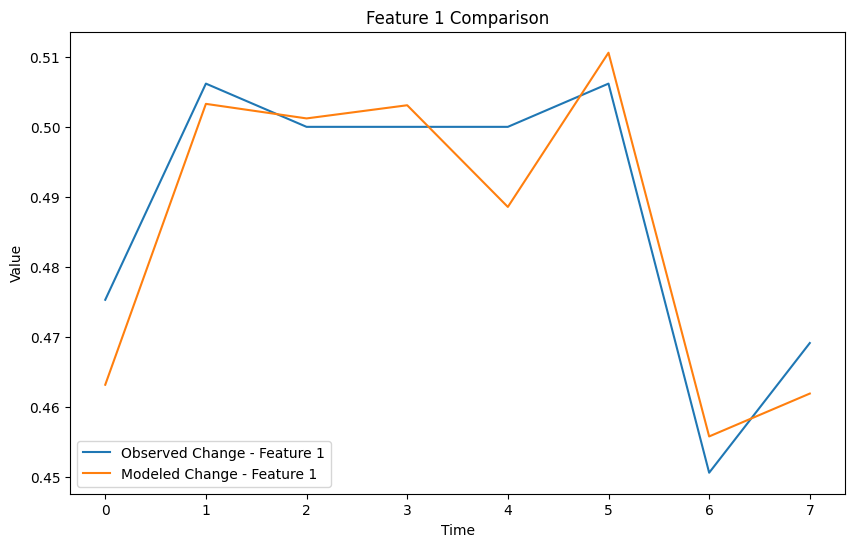

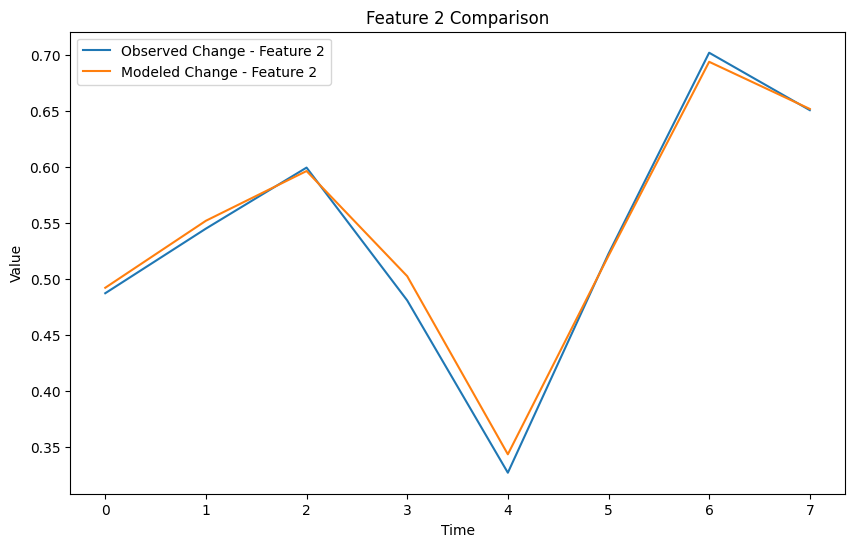

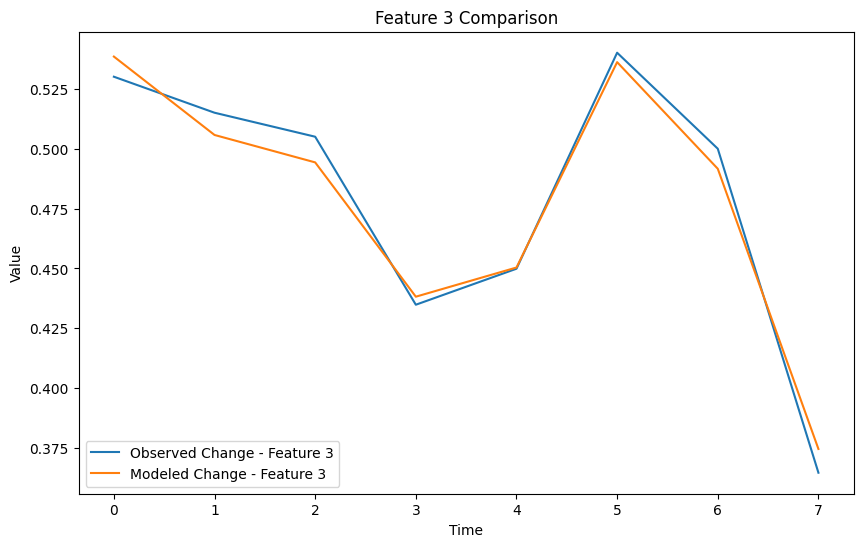

In [22]:
# Intialize Response Generator
generator = ResponseGenerator(model, preparer.sliced_data, feature_indexes, preparer.max_change_dfs)

# Generate a response for a specific index
sel_index = 123
generator.generate_response(sel_index)

generator.plot_normalized_responses()

### Unscaled Response Review

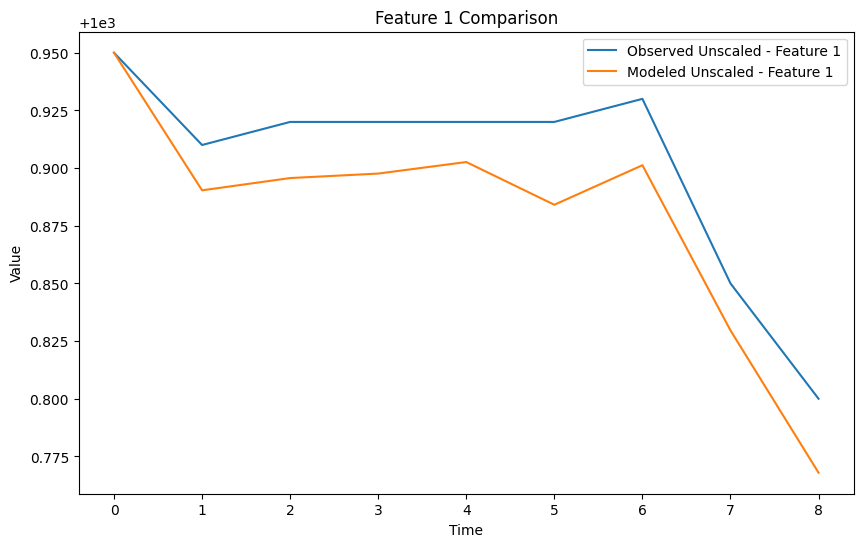

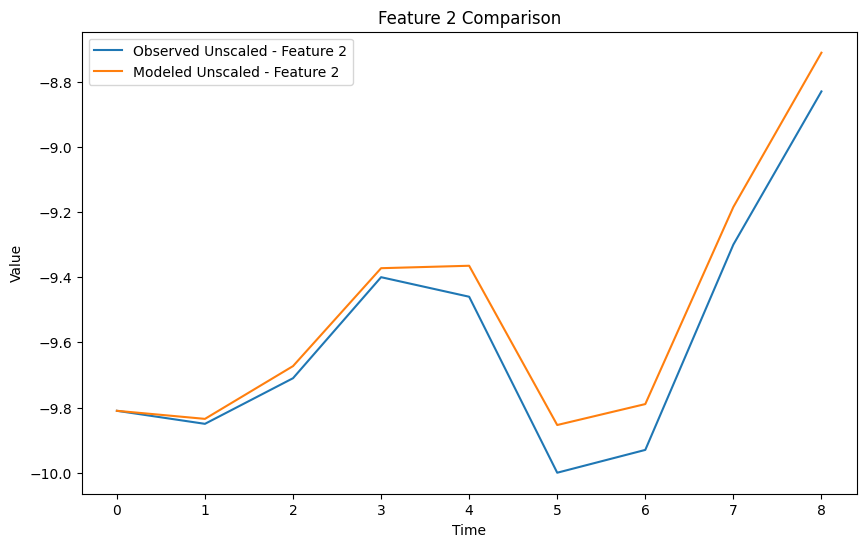

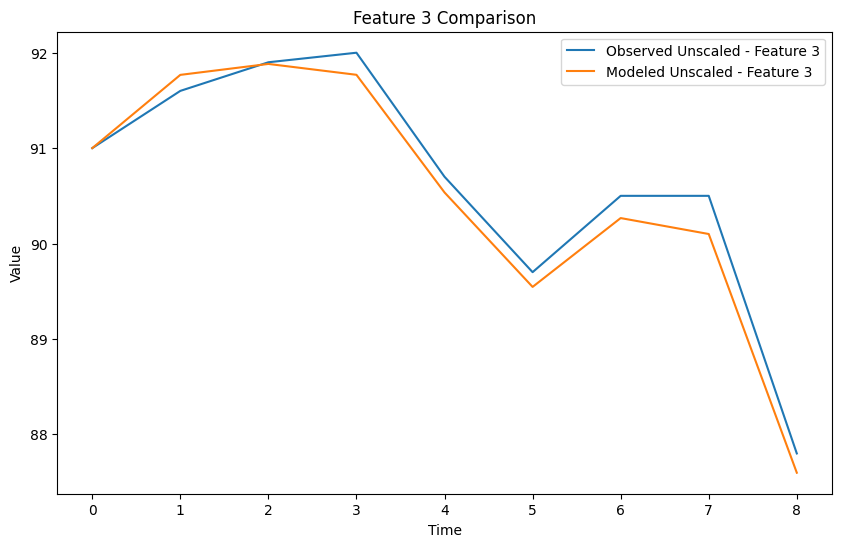

In [23]:
generator.plot_unscaled_responses(preparer.min_max_df, feature_indexes)